In [1]:
# Joseph Gufford
# Fall 2024 
# 02 October 2024
# Function Fitting Assignment -Assignment 01

# imports libraries
# creates top scope level constants
# creates base functions to be used
import numpy as np
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import copy

# Top scope level variables
m= 1/15000000 # map scale value
rho = 6371*1000 # radius of earth in meters
phi0 = 60 # phi naught  - intersecting plane at 60 deg North
lamb0 = -115 # 115 degrees longitude West

def getData(mydatapath:str):
    with open(mydatapath) as f:
        myfile = f.read().splitlines() #splits by newlines 
        
    myfile = [x.split(",") for x in myfile] # list of lines split be delimiter
    
    newArr = [None for x in range(len(myfile))] # index for station tracking
    floatArr = np.zeros((135,6),dtype='float') # floating point conversion
    # watch out for  floating point comparison as station ids are floats 
    for i in range(len(myfile)):
        # list of dictionaries. One dict for each station
        newArr[i] = { "Station":myfile[i][0],
                     "Latitude":myfile[i][1],
                     "Longitude":myfile[i][2],
                     "500mb Height":myfile[i][3],
                     "500mb Wind Direction":myfile[i][4],
                     "500mb Wind Speed": myfile[i][5] }  
        floatArr[i][0] = i # loop var same as station index
        floatArr[i][1:] = [float(x) for x in myfile[i][1:]] 
        # convert rest of items in sub-list  from str to float and pass it to array
    return floatArr
#==============================================================================
# this function converts our lats/lons of observations to x-y space
def ConvertMapCoords(coordArray: list,phi0=60,lamb0= -115): # preferably a numpy.ndarray

    radCoord = coordArray[:,1:3].copy()
    radCoord[:,1] = radCoord[:,1] - lamb0
    radCoord = radCoord * np.pi/180.0
    # fun times with lambda functions! 
    sigma = lambda phi,phi0=60: (1+np.sin(phi0 * np.pi/180)) / (1 + np.sin(phi)) 
    
    dataX = rho*sigma(radCoord[:,0]) * np.cos(radCoord[:,0])*np.cos(radCoord[:,1])
    dataY = rho*sigma(radCoord[:,0]) * np.cos(radCoord[:,0])*np.sin(radCoord[:,1])
    # transform data by map factor and then put into cm
    # WHY DID I DO NEGATIVE DATAY HERE?
    # it was because i reversed a formula lol. 
    return np.stack((coordArray[:,0],dataX,dataY,coordArray[:,3]),axis=1)
#==============================================================================
#this converts our x/y grid to map space. Input is in IMAGE PLANE METERS
def convertXYtoLatLon(xnew1,ynew1):
    xnew1 = np.copy(xnew1)
    ynew1 = np.copy(ynew1)
    mapX  = -115 + np.arctan(ynew1/xnew1)*180/np.pi # our xy grid in lat/lon space
    arg1 = np.power(((xnew1)**2 + (ynew1)**2),0.5)
    arg2 = (rho*(1+np.sin(phi0*np.pi/180.)))
    mapY = (np.pi/2 - 2*np.arctan(arg1/arg2))*180/np.pi

    return [mapX,mapY]
#==============================================================================
def makeMyGrid(X0=18.90,Y0=-6.30):
    
    #X0 = 18.90 #cm # x start value
    #Y0 = -6.30 #cm # y start value
    
    # input must be in radians. Fancy lamba functions!     
    # Creation of our analysis grid in x-y space
    #x_grid = np.linspace(X0,X0+1.27*21,22)
    #y_grid = np.linspace(Y0,Y0+1.27*27,28) # keeping in cm for now
    x_grid = 18.9 + np.arange(22)*1.27
    y_grid = -6.30 + np.arange(28)*1.27
    
    xnewO,ynewO = np.meshgrid(x_grid,y_grid) # this is our np.meshgrid
    xnewM = xnewO/100/m #convert to image plane
    ynewM = ynewO/100/m #convert to image plane
    return [xnewM,ynewM,xnewO,ynewO] # THIS WILL BE HUGE NUMBER IN METERS
    # O stands for Original cm, M stands for Meters
#==============================================================================
def findCloseValues(xnew,ynew,stationMapSpace,ROI:int):
    filteredDict = []
    myNumObs = np.zeros((28,22))
    stationMapSpace = np.copy(stationMapSpace) # since we're editing stuff
    stationMapSpace[:,1:3] = stationMapSpace[:,1:3]*m*100 # we are in map space (cm) now

    for i in range(xnew.shape[0]):
        for j in range(xnew.shape[1]):
            #print(np.max(xnew),np.max(ynew))
            distanceFilter = np.sqrt( (xnew[i,j] - stationMapSpace[:,1])**2 + \
            (ynew[i,j] - stationMapSpace[:,2])**2)
            
            filteredList= stationMapSpace[distanceFilter<ROI]
            myNumObs[i,j] = len(filteredList)

            filteredDict.append({"x": i, "y":j, 
            "filteredObs":copy.deepcopy(filteredList) }  )
    # RETURN VALUE IS NOW IN CENTIMETERS SPACE!
    return [filteredDict,myNumObs]
#==============================================================================
def doAnalysisEquation(Xnew,Ynew,filteredDictionary):
    #Xnew in cm, Ynew in cm, filteredDictionary in cm
    FinalAnalysis = np.zeros((28,22)) # final array we have for height analysis field

    for i in range(len(filteredDictionary)):
        # TRY 262 for this. it gosh darn gives -1223.27341419
        # TRY 459 gives 459 6676.263175332868 
        tester = filteredDictionary[i] #doing a single test here
        
        if len(tester["filteredObs"]) == 0:
            print("temp")
            continue
        mypoint = [tester["x"], tester["y"] ]
        xkprior = tester["filteredObs"][:,1] - (Xnew[ tester["x"], tester["y"] ]) #how far we from analyis grid
        ykprior = tester["filteredObs"][:,2] - (Ynew[ tester["x"], tester["y"] ]) #how far we from analyis grid
    
        checker = np.sqrt(xkprior**2 + ykprior**2)
        #-----    
        xk = np.mean(xkprior)
        yk = np.mean(ykprior)
        yk2 = np.mean(ykprior**2)
        yk3 = np.mean(ykprior**3)
        yk4 = np.mean(ykprior**4)
        
        xk2 = np.mean(xkprior**2)
        xk3 = np.mean(xkprior**3)
        xk4 = np.mean(xkprior**4)
        
        xkyk = np.mean(xkprior*ykprior)
        xk2_yk = np.mean(xkprior**2 * ykprior)
        xk3_yk = np.mean(xkprior**3 * ykprior)
        
        xk_yk2 = np.mean(xkprior * ykprior**2)
        xk_yk3 = np.mean(xkprior * ykprior**3)
        xk2_yk2 = np.mean(xkprior**2 * ykprior**2)
        
        fullArr = np.zeros((6,6))      
        fullArr[:,0] = np.asarray([1,xk,yk,xk2,yk2,xkyk])
        fullArr[:,1] = np.asarray([xk, xk2, xkyk, xk3, xk_yk2, xk2_yk])
        fullArr[:,2] = np.asarray([yk, xkyk, yk2, xk2_yk, yk3, xk_yk2])
        fullArr[:,3] = np.asarray([xk2, xk3, xk2_yk, xk4, xk2_yk2, xk3_yk])
        fullArr[:,4] = np.asarray([yk2, xk_yk2, yk3, xk2_yk2,yk4,xk_yk3])
        fullArr[:,5] = np.asarray([xkyk, xk2_yk, xk_yk2, xk3_yk, 
                                   xk_yk3, xk2_yk2])   
        # right h
        rightVectorList = np.asarray(
            [
             np.mean( tester["filteredObs"][:,3])                 ,
             np.mean( xkprior * tester["filteredObs"][:,3])       ,
             np.mean( ykprior*tester["filteredObs"][:,3])         ,
             np.mean( xkprior**2 * tester["filteredObs"][:,3])    ,
             np.mean( ykprior**2 * tester["filteredObs"][:,3])    ,
             np.mean( xkprior * ykprior * tester["filteredObs"][:,3])
         ]
            )      
        rr = np.matrix(rightVectorList).T
        
        myinv = np.linalg.inv(np.matrix(fullArr))
        coeffs = myinv @ rr # this is matrix multiplication operator

        FinalAnalysis[mypoint[0], mypoint[1]] =  np.copy(coeffs[0,0])
        
        # this collects the points that won't  work. 
        if abs(coeffs[0,0] - 5000) > 1000:
            #print(i, Xnew[mypoint[0],mypoint[1]], Ynew[mypoint[0],mypoint[1]])
            print(i,coeffs)
            #terrible.append(i)

    return FinalAnalysis
#==============================================================================
def mapPlotter(mapX,mapY,myNumObs,FinalAnalysis,ROI:int):
     levels = np.arange(5280,6060,60)
     ax = plt.axes( projection=ccrs.NorthPolarStereo(central_longitude=-115))
     ax.gridlines()
     CountCountour = ax.contour(mapX,mapY,myNumObs,transform=ccrs.PlateCarree(),colors='k')
     ax.clabel(CountCountour, inline=True, fontsize=10,colors="r")

     ax.coastlines("10m", alpha=1, zorder=2)
     ax.add_feature(cfeature.BORDERS, linestyle='--')
     state_borders = cfeature.NaturalEarthFeature(category='cultural',
                                name='admin_1_states_provinces_lakes',
                                scale='50m', facecolor='None',linestyle='--',
                                linewidth=0.75)
     ax.add_feature(state_borders, edgecolor='black')
     plt.title("Count of stations within a " + str(ROI) + "cm radius of influence")

     plt.show()
     
     plt.clf()
     
     levels = np.arange(5280,6060,60)
     ax = plt.axes( projection=ccrs.NorthPolarStereo(central_longitude=-115))
     ax.gridlines()
     thisContour = ax.contour(mapX,mapY,FinalAnalysis,levels = levels,transform=ccrs.PlateCarree(),zorder=2,colors="r")
     ax.clabel(thisContour, inline=True, fontsize=10,colors="r")

     ax.coastlines("10m", alpha=1, zorder=2)
     ax.add_feature(cfeature.BORDERS, linestyle='--')
     state_borders = cfeature.NaturalEarthFeature(category='cultural',
                                name='admin_1_states_provinces_lakes',
                                scale='50m', facecolor='None',linestyle='--',
                                linewidth=0.75)
     ax.add_feature(state_borders, edgecolor='black')    
     plt.title("500 mb height Analysis with a " + str(ROI) + "cm radius of influence")
     plt.show()
    #==========================================================================================
def AnalysisFile(filterDict,xnewCM,ynewCM,mapX,mapY,FinalAnalysisFile,NumStations,ROI:int,delim=","):
    header = ["i-index (unitless)","j-index (unitless)",
              "X-value (cm)","Y-value (cm)","Longitude (deg)", 
              "Latitude (deg)","Station Count","500mb Height Analysis (m)"]
    
    header = delim.join([str(x) for x in header])    
    
    logfile = []
    logfile.append(header)
    for i in range(len(filterDict)):
        thisrow = [0,0,0,0,0,0,0,0]
        
        tester = filterDict[i]
        if len(tester["filteredObs"]) == 0:
            print("temp")
            #continue
        mypoint = [tester["x"], tester["y"] ]
        thisrow[0] = tester["x"]
        thisrow[1] = tester["y"]
        thisrow[2] = np.round(xnewCM[ tester["x"], tester["y"]],4)
        thisrow[3] = np.round( ynewCM[ tester["x"], tester["y"]],4)
        thisrow[4] = np.round(mapX[tester["x"], tester["y"]],4)
        thisrow[5] = np.round(mapY[tester["x"], tester["y"]],4)
        thisrow[6] = NumStations[tester["x"],tester["y"] ]
        thisrow[7] = np.round(FinalAnalysisFile[tester["x"], tester["y"]],4)
        
        # delimiter is just a comma
        arg = delim.join([str(x) for x in thisrow])
        logfile.append(arg)
        
    logfile = "\n".join(logfile)
    newFilename = "JoeAnalysis" + str(ROI) + ".csv"
    with open(newFilename, "w") as fileToWrite:
        fileToWrite.write(logfile)
        
    return [logfile,newFilename]
    


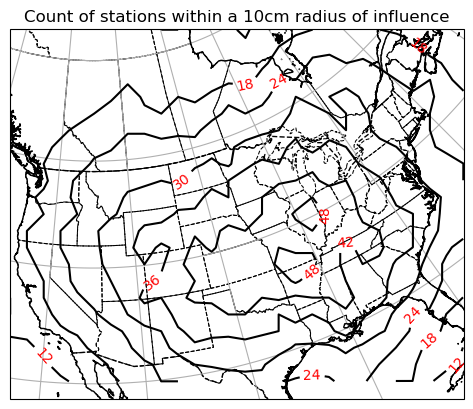

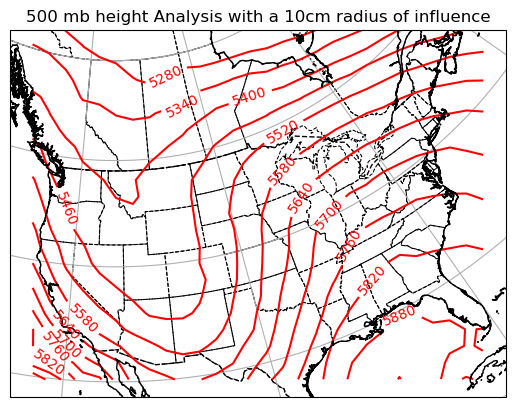

[['i-index (unitless)', 'j-index (unitless)', 'X-value (cm)', 'Y-value (cm)', 'Longitude (deg)', 'Latitude (deg)', 'Station Count', '500mb Height Analysis (m)'], ['0', '0', '18.9', '-6.3', '-133.4349', '61.7802', '18.0', '5307.8066'], ['0', '1', '20.17', '-6.3', '-132.3459', '60.1426', '15.0', '5345.0398'], ['0', '2', '21.44', '-6.3', '-131.3751', '58.5082', '15.0', '5364.2474'], ['0', '3', '22.71', '-6.3', '-130.5046', '56.8793', '15.0', '5388.4913'], ['0', '4', '23.98', '-6.3', '-129.72', '55.2575', '16.0', '5405.5429'], ['0', '5', '25.25', '-6.3', '-129.0095', '53.6445', '13.0', '5421.6989'], ['0', '6', '26.52', '-6.3', '-128.3633', '52.0415', '15.0', '5441.4716'], ['0', '7', '27.79', '-6.3', '-127.7731', '50.4498', '14.0', '5477.8721'], ['0', '8', '29.06', '-6.3', '-127.232', '48.8702', '16.0', '5494.7595']]


In [2]:
# This is the plotting for a 10 cm radius of influence

mydatapath = "RAOBs_201903131200.txt"
ROI = 10
floatArr = getData(mydatapath)
stationInMapSpace = ConvertMapCoords(floatArr) # we are in image space now. NOT MAP SPACE
xnewIM,ynewIM,xnewCM,ynewCM = makeMyGrid() #IM means meter image space, cm=cm
mapX,mapY = convertXYtoLatLon(xnewIM,ynewIM)

filteredDictXcm, myObsX_Count = findCloseValues(xnewCM,ynewCM,stationInMapSpace,ROI)
FinalAnalysis = doAnalysisEquation(xnewCM, ynewCM, filteredDictXcm)
mapPlotter(mapX,mapY,myObsX_Count,FinalAnalysis,ROI)
logfile,newFilename = AnalysisFile(filteredDictXcm,xnewCM,ynewCM,mapX,mapY,FinalAnalysis,myObsX_Count,ROI)
with open(newFilename) as f:
    myfile = f.read().splitlines()[0:10] #splits by newlines
myfile = [x.split(",") for x in myfile] # list of lines split be delimiter
print(myfile)

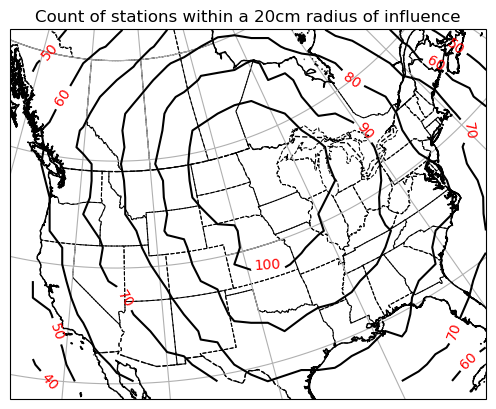

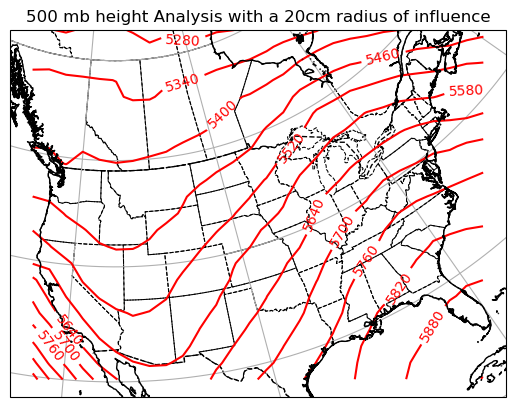

In [3]:
# This is the plotting for a 20 cm radius of influence
mydatapath = "RAOBs_201903131200.txt"
ROI = 20
floatArr = getData(mydatapath)
stationInMapSpace = ConvertMapCoords(floatArr) # we are in image space now. NOT MAP SPACE
xnewIM,ynewIM,xnewCM,ynewCM = makeMyGrid() #IM means meter image space, cm=cm
mapX,mapY = convertXYtoLatLon(xnewIM,ynewIM)

filteredDictXcm, myObsX_Count = findCloseValues(xnewCM,ynewCM,stationInMapSpace,ROI)
FinalAnalysis = doAnalysisEquation(xnewCM, ynewCM, filteredDictXcm)
mapPlotter(mapX,mapY,myObsX_Count,FinalAnalysis,ROI)
logfile,newFilename = AnalysisFile(filteredDictXcm,xnewCM,ynewCM,mapX,mapY,FinalAnalysis,myObsX_Count,ROI)
with open(newFilename) as f:
    myfile = f.read().splitlines()[0:10] #splits by newlines
myfile = [x.split(",") for x in myfile] # list of lines split be delimiter
